In [1]:
import numpy as np
import torch 
from torch import optim, softmax
import torch.nn as nn 
import scipy
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm as tqdm
from tqdm import *
import seaborn

In [2]:
from training import double_train, x
from utils import affine_transformation, gaussian_icdf, gmm_2modes_icdf, quadratic, quartic
from plot_helpers import params_recovery, loss_fit

## PARAMS : AFFINE; QUADRATIC; ENTROPY

In [19]:
G = affine_transformation()
D = quadratic(3, 1) #change init to check robustness 
learning_rate = 1e-4
epochs= 500000
entropy = True

In [20]:
lg, muq, logsigmaq, ld, muk, logsigmak = double_train(x, G, D, learning_rate, epochs, entropy)

100%|██████████| 500000/500000 [09:13<00:00, 903.39it/s]


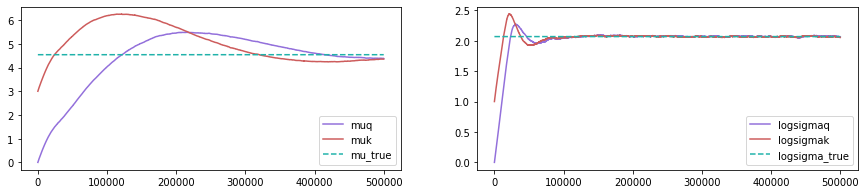

In [21]:
params_recovery(D, muq, logsigmaq, muk, logsigmak, training='double')

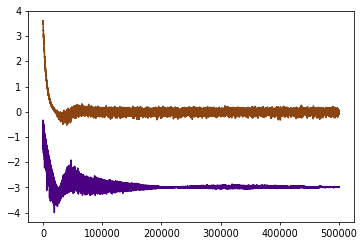

100%|██████████| 100000/100000 [00:10<00:00, 9257.48it/s]


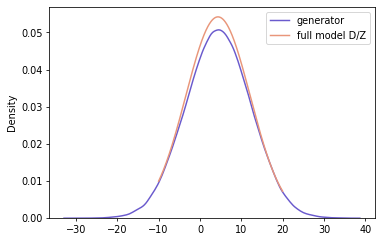

In [22]:
loss_fit(lg, ld, muq, logsigmaq,  muk, logsigmak, G, D, training='double')

## PARAMS: AFFINE, QUADRATIC, NO ENTROPY

In [3]:
G = affine_transformation()
D = quadratic(3, 1) #change init to check robustness 
learning_rate = 1e-4
epochs= 500000
entropy = False

In [4]:
lg, muq, logsigmaq, ld, muk, logsigmak = double_train(x, G, D, learning_rate, epochs, entropy)

100%|██████████| 500000/500000 [08:18<00:00, 1003.37it/s]


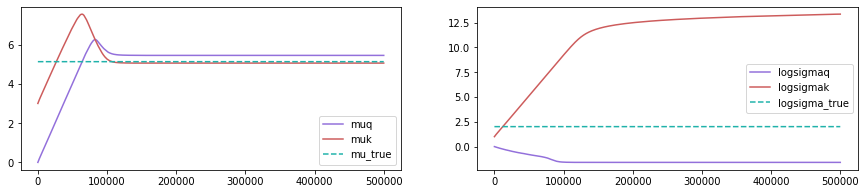

In [5]:
params_recovery(D, muq, logsigmaq, muk, logsigmak, training='double')

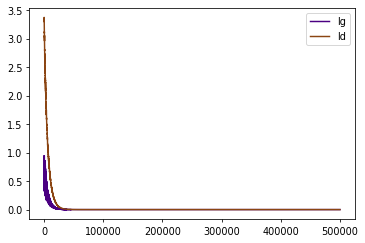

100%|██████████| 100000/100000 [00:11<00:00, 8890.32it/s]


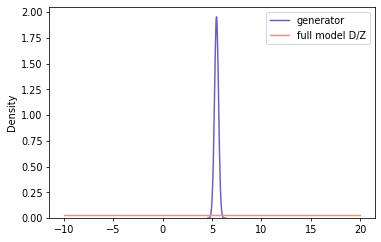

In [6]:
loss_fit(lg, ld, muq, logsigmaq,  muk, logsigmak, G, D, training='double')

## PARAMS: GAUSSIAN ICDF, QUADRATIC, ENTROPY

In [3]:
G = gaussian_icdf()
D = quadratic(3, 1) #change init to check robustness 
learning_rate = 1e-4
epochs= 500000 #400000 
entropy = True

In [4]:
lg, muq, logsigmaq, ld, muk, logsigmak = double_train(x, G, D, learning_rate, epochs, entropy)

100%|██████████| 400000/400000 [07:04<00:00, 941.81it/s]


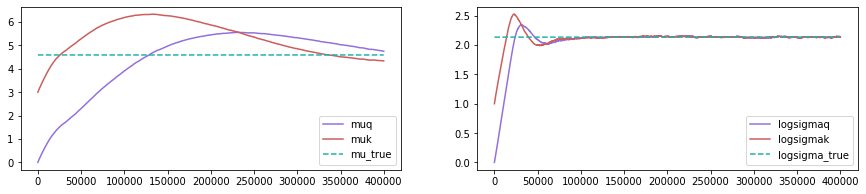

In [5]:
params_recovery(D, muq, logsigmaq, muk, logsigmak, training='double')

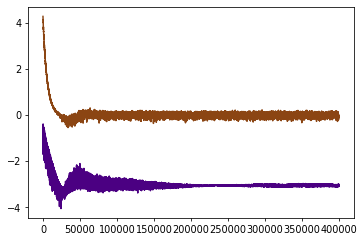

100%|██████████| 100000/100000 [00:08<00:00, 11200.89it/s]


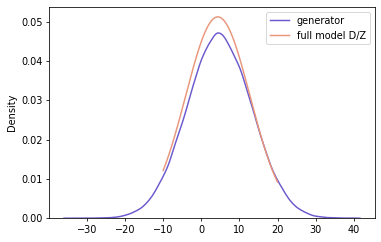

In [6]:
loss_fit(lg, ld, muq, logsigmaq,  muk, logsigmak, G, D, training='double')

## PARAMS: GAUSSIAN ICDF, QUADRATIC, NO ENTROPY

In [3]:
G = gaussian_icdf()
D = quadratic(3, 1) #change init to check robustness 
learning_rate = 1e-4
epochs= 500000
entropy = False

In [4]:
lg, muq, logsigmaq, ld, muk, logsigmak = double_train(x, G, D, learning_rate, epochs, entropy)

100%|██████████| 500000/500000 [07:37<00:00, 1091.79it/s]


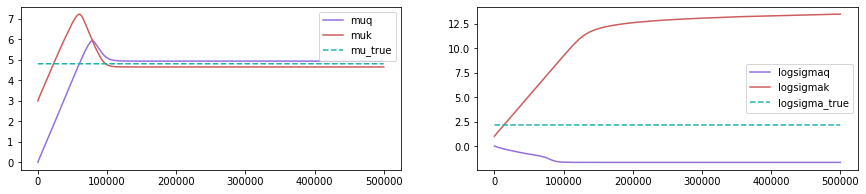

In [5]:
params_recovery(D, muq, logsigmaq, muk, logsigmak, training='double')

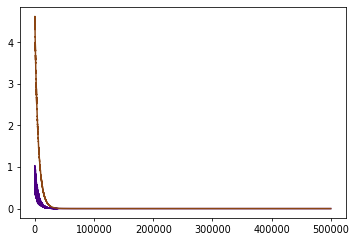

100%|██████████| 100000/100000 [00:08<00:00, 11206.63it/s]


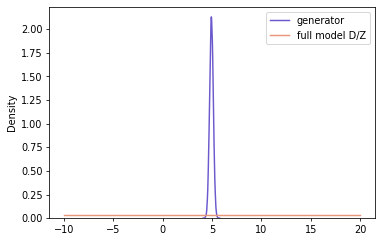

In [6]:
loss_fit(lg, ld, muq, logsigmaq,  muk, logsigmak, G, D, training='double')

## PARAMS: GMM ICDF, QUARTIC, ENTROPY

In [3]:
G = gmm_2modes_icdf()
D = quartic() 
learning_rate = 1e-4
epochs= 200000#120000#500000
entropy = True

In [4]:
G.mu_q, G.log_sigma_q, G.weights

(Parameter containing:
 tensor([0., 7.], requires_grad=True),
 Parameter containing:
 tensor([1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True))

In [5]:
D.theta1, D.theta2, D.theta3, D.theta4

(Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([10.], requires_grad=True),
 Parameter containing:
 tensor([-35.], requires_grad=True),
 Parameter containing:
 tensor([50.], requires_grad=True))

  0%|          | 0/100000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 100000/100000 [00:20<00:00, 4951.07it/s]


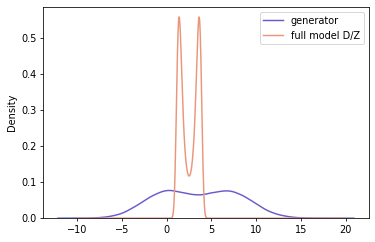

In [6]:
sampled_gen = []
for _ in tqdm(range(100000)):
    eps = G.simulate()
    sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())

xmin = -10
xmax = 20
xx = torch.Tensor(np.linspace(xmin,xmax,1000))
Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

fig, ax = plt.subplots()
seaborn.kdeplot(np.hstack(sampled_gen), label='generator', color = 'slateblue') #kernel density plot 
ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z', color = 'darksalmon')
ax.legend()
fig.set_dpi(70)

In [7]:
def double_train_multi(x, G, D, learning_rate, epochs, entropy):
    logd = D.logd
    lg=[]
    ld=[]
    optimizer_D=optim.Adam([D.theta1, D.theta2, D.theta3, D.theta4], lr=learning_rate)
    optimizer_G=optim.Adam([G.mu_q, G.log_sigma_q, G.weights],lr=learning_rate)
    for param in G.parameters():
        param.requires_grad = True
    for param in D.parameters():
        param.requires_grad = True
        
    for epoch in tqdm(range(epochs)):
        eps = G.simulate()
        x_ = G.noise_to_x(eps)
        
        ##### DISCRIMINATOR'S TRAINING #####
        
        optimizer_D.zero_grad()
        loss_D = - torch.mean(logd(x)) + torch.mean(logd(x_))
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        ld.append(loss_D.item())
        
        #define q (entropy)
        q = torch.distributions.Normal(G.mu_q, torch.exp(G.log_sigma_q))
        
        ##### GENERATOR'S TRAINING #####
        
        optimizer_G.zero_grad()
        loss_G = - torch.mean(logd(x_)) + torch.mean(G.logprob(x_))
        loss_G.backward(retain_graph=True)
        optimizer_G.step()
        
        lg.append(loss_G.item())
        
       # if epoch%400==0 or epoch == (epochs-1) :
       #     sampled_gen = []
       #     for _ in range(1000):
       #         eps = G.simulate()
       #         sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())
        
       #     xmin = -10
       #     xmax = 20
       #     xx = torch.Tensor(np.linspace(xmin,xmax,1000))
       #     Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

        #    fig, ax = plt.subplots()
        #   seaborn.kdeplot(np.hstack(sampled_gen), label='generator', color = 'slateblue') #kernel density plot 
        #    ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z', color = 'darksalmon')
        #    ax.legend()
        #    fig.set_dpi(70)
        #    fig.show()

        #logZ = log_quadrature(logd, xmin, xmax, it)
        #lb = lower_bound_torch(logd, G, optimizer_G, 0, it)
        #print('lb=',lb.item(), 'logZ=',logZ.item())
        #print(D.theta1, D.theta2, D.theta3, D.theta4)

        #plt.figure()
        #plt.plot(xx, (torch.exp(logd(xx)-lb)).detach().numpy(), label = 'D/approx_Z')
        #seaborn.kdeplot(np.hstack(x), label='data') 
        #plt.legend()
        #plt.show()

    return lg, ld

In [8]:
lg, ld = double_train_multi(x, G, D, learning_rate, epochs, entropy)

  0%|          | 0/200000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
/mnt/nfs/home/i.sebag/PWGAN2/utils.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 200000/200000 [06:33<00:00, 508.59it/s]


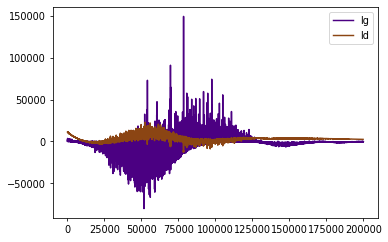

In [9]:
fig, ax = plt.subplots()
plt.plot(np.convolve(lg,np.ones(10)/10)[10:len(lg)-10], label = 'lg', color = 'indigo')
plt.plot(np.convolve(ld,np.ones(100)/100)[100:len(ld)-100], label = 'ld', color = 'saddlebrown')
fig.set_dpi(70)
plt.legend()
plt.show()

In [10]:
G.mu_q, G.log_sigma_q, G.weights

(Parameter containing:
 tensor([ 6.0346, 11.8363], requires_grad=True),
 Parameter containing:
 tensor([ 1.2971, -0.4661], requires_grad=True),
 Parameter containing:
 tensor([-0.2134,  1.2134], requires_grad=True))

In [11]:
D.theta1, D.theta2, D.theta3, D.theta4

(Parameter containing:
 tensor([-1.2714], requires_grad=True),
 Parameter containing:
 tensor([6.4696], requires_grad=True),
 Parameter containing:
 tensor([-38.4764], requires_grad=True),
 Parameter containing:
 tensor([40.4228], requires_grad=True))

In [12]:
sampled_gen = []
for _ in tqdm(range(100000)):
    eps = G.simulate()
    sampled_gen.append(G.noise_to_x(eps).detach().numpy().item())

  0%|          | 0/100000 [00:00<?, ?it/s]/mnt/nfs/home/i.sebag/PWGAN2/utils.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_weights = F.softmax(self.weights)
100%|██████████| 100000/100000 [00:20<00:00, 4866.65it/s]


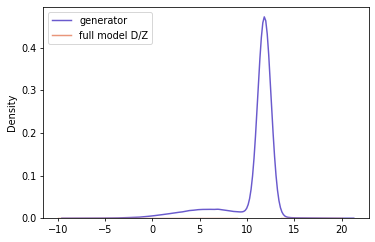

In [15]:
xmin = -10
xmax = 20
xx = torch.Tensor(np.linspace(xmin,xmax,1000))
Z = torch.mean(torch.exp(D.logd(xx))) * (xmax - xmin) 

fig, ax = plt.subplots()
seaborn.kdeplot(np.hstack(sampled_gen), label='generator', color = 'slateblue') #kernel density plot 
ax.plot(xx, (torch.exp(D.logd(xx))/Z).detach().numpy(), label ='full model D/Z', color = 'darksalmon')
ax.legend()
fig.set_dpi(70)

## PARAMS: GMM ICDF, QUARTIC, NO ENTROPY

In [ ]:
G = gmm_2modes_icdf()
D = quartic() 
learning_rate = 1e-4
epochs= 500000
entropy = False

In [ ]:
lg, muq, logsigmaq, ld, muk, logsigmak = double_train(x, G, D, learning_rate, epochs, entropy)

  7%|▋         | 37314/500000 [00:43<08:43, 883.13it/s]

In [ ]:
loss_fit(lg, ld, muq, logsigmaq,  muk, logsigmak, G, D, training='double')